<a href="https://colab.research.google.com/github/Skander28/LastWork/blob/main/lastBilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.2 MB/s eta 0:00:00


In [2]:
import nltk
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import numpy as np
import string, re

from google.colab import drive
drive.mount('/content/drive')

# Read the given dataset which contain the Ids
filtered_df = pd.read_csv('/content/drive/MyDrive/Thisone.csv',lineterminator='\n')
filtered_df.head()

Mounted at /content/drive


,Unnamed: 0,id,text,dialect,word_count,char_count
0,0,1152861142416576384,طيب اعرفو رئيس وزرائكم الاول وتعالو حاسبو رياض...,DZ,9,57
1,1,921392744878264448,@khaireddineroub اوكي ماتنساش روراوة ثاني لازم...,DZ,16,94
2,2,960133615689576448,@safasafa2339 يا ختي ديجا كي نشوف سمو نبدا نرج...,DZ,12,54
3,3,1121522092581769216,اوو وش لي مش وخدين بلنا منو,DZ,7,30
4,4,1187345510874656768,@Hadjer12345678 تقولي راكي تهدري عليا 😂😂😂,DZ,6,41


In [3]:
filtered_df['dialect'].value_counts()

DZ    18007
LY    18007
MA    18007
TN    18007
Name: dialect, dtype: int64

In [4]:

# arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
# english_punctuations = string.punctuation
# punctuations_list = arabic_punctuations + english_punctuations


# def remove_punctuations(text):
#     translator = str.maketrans('', '', punctuations_list)
#     return text.translate(translator)
  

# filtered_df['text'] = filtered_df['text'].apply(remove_punctuations)
# filtered_df.head()

In [5]:
# def remove_emoji(string):
#     emoji_pattern = re.compile("["
#                                u"\U0001F600-\U0001F64F"  # emoticons
#                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                                u"\U00002500-\U00002BEF"  # chinese char
#                                u"\U00002702-\U000027B0"
#                                u"\U00002702-\U000027B0"
#                                u"\U000024C2-\U0001F251"
#                                u"\U0001f926-\U0001f937"
#                                u"\U00010000-\U0010ffff"
#                                u"\u2640-\u2642"
#                                u"\u2600-\u2B55"
#                                u"\u200d"
#                                u"\u23cf"
#                                u"\u23e9"
#                                u"\u231a"
#                                u"\ufe0f"  # dingbats
#                                u"\u3030"
#                                "]+", flags=re.UNICODE)
#     return emoji_pattern.sub(r'', string)


# filtered_df['text'] = filtered_df['text'].apply(remove_emoji)
# filtered_df.head()

In [6]:
# def remove_non_arabic(text):
#     text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
#     text = re.sub('([@A-Za-z0-9_ـــــــــــــ]+)|[^\w\s]|#|http\S+',' ',text)
#     text = re.sub(r'\\u[A-Za-z0-9]\\+',' ',text)         #'\u003c\1'  error
#     return text


# filtered_df['text'] = filtered_df['text'].apply(remove_non_arabic)
# filtered_df.head()

In [7]:
# nltk.download('stopwords')
# stop=stopwords.words('arabic')

# filtered_df['text'] = filtered_df['text'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))
# filtered_df.head()

In [8]:
# import re, string

# def data_cleaning (text):
#   try:
#     text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
#     text = re.sub(r'^http?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
#     text = re.sub(r"http\S+", "", text)
#     text = re.sub(r"https\S+", "", text)
#     text = re.sub(r'\s+', ' ', text)
#     text = re.sub("(\s\d+)","",text) 
#     text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
#     text = re.sub("\d+", " ", text)
#     text = text.replace("#", " ");
#     text = text.replace("@", " ");
#     text = text.replace("_", " ");
#   except:
#     return text
   
#   return text

# # Cleaning Training Data 
# filtered_df['text'] = filtered_df['text'].apply(lambda x:   data_cleaning(x))

In [9]:
import sentencepiece as spm


In [10]:
text_data = filtered_df['text'].tolist()

In [11]:
with open('tweets.txt', 'w', encoding='utf-8') as file:
    for tweet in text_data:
        file.write(tweet + '\n')


In [12]:
# Define the SentencePiece model path and vocabulary size
model_prefix = 'maghrebi_model'
vocab_size = 25000
max_length = 200

# Train the SentencePiece tokenizer
spm.SentencePieceTrainer.train(
    f'--input=tweets.txt --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type=unigram'
)


In [13]:
from torch.nn.utils.rnn import pad_sequence
# Load the trained SentencePiece tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.load(f'{model_prefix}.model')

# Tokenize the text data
tokenized_data = [tokenizer.encode(text) for text in text_data]
tokenized_data = pad_sequences(tokenized_data, maxlen=max_length)

In [14]:
labels = pd.get_dummies(filtered_df['dialect']).values

In [15]:
#Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(tokenized_data, labels, test_size=0.05, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42, shuffle=True)

In [16]:
# from imblearn.over_sampling import RandomOverSampler

# # Create an instance of RandomOverSampler
# oversampler = RandomOverSampler(random_state=42)

# # Apply oversampling to X_train and y_train
# X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train,y_train)

In [17]:
# from imblearn.under_sampling import RandomUnderSampler

# # Undersampling X_val and y_val
# undersampler = RandomUnderSampler(random_state=42)
# X_val_resampled, y_val_resampled = undersampler.fit_resample(X_val, y_val)

# # Undersampling X_test and y_test
# X_test_resampled, y_test_resampled = undersampler.fit_resample(X_test, y_test)


In [18]:
import numpy as np

# Convert the one-hot encoded labels back to dialect labels
dialect_labels = np.argmax(labels, axis=1)
# Get the unique dialect labels and their counts in the original dataset
unique_dialects, dialect_counts = np.unique(dialect_labels, return_counts=True)

# Get the number of samples for each dialect in the training set
train_dialect_labels = np.argmax(y_train, axis=1)
train_dialect_counts = np.bincount(train_dialect_labels, minlength=len(unique_dialects))

# Get the number of samples for each dialect in the validation set
val_dialect_labels = np.argmax(y_val, axis=1)
val_dialect_counts = np.bincount(val_dialect_labels, minlength=len(unique_dialects))

# Get the number of samples for each dialect in the test set
test_dialect_labels = np.argmax(y_test, axis=1)
test_dialect_counts = np.bincount(test_dialect_labels, minlength=len(unique_dialects))

# Map dialect labels to their corresponding names
dialect_names = ["DZ", "LY", "MA", "TN"] 

# Print the number of samples for each dialect in each set
for dialect, train_count, val_count, test_count in zip(unique_dialects, train_dialect_counts, val_dialect_counts, test_dialect_counts):
    dialect_name = dialect_names[dialect]
    print(f"{dialect_name}: Train={train_count}, Val={val_count}, Test={test_count}")

DZ: Train=16283, Val=860, Test=864
LY: Train=16251, Val=834, Test=922
MA: Train=16210, Val=866, Test=931
TN: Train=16260, Val=862, Test=885


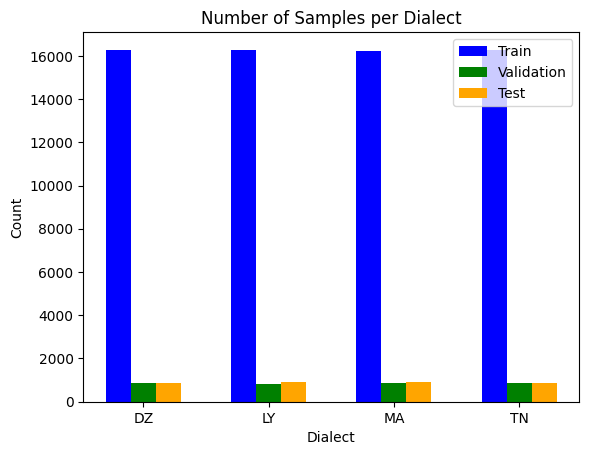

In [19]:
import matplotlib.pyplot as plt

# Define the dialect names and colors for plotting
dialect_names = ["DZ", "LY", "MA", "TN"]
colors = ["blue", "green", "orange", "red"]

# Collect the counts for each set
train_counts = train_dialect_counts.tolist()
val_counts = val_dialect_counts.tolist()
test_counts = test_dialect_counts.tolist()

# Plot the counts
x = np.arange(len(dialect_names))
width = 0.2

fig, ax = plt.subplots()
train_bars = ax.bar(x - width, train_counts, width, label='Train', color=colors[0])
val_bars = ax.bar(x, val_counts, width, label='Validation', color=colors[1])
test_bars = ax.bar(x + width, test_counts, width, label='Test', color=colors[2])

# Add labels, title, and legend
ax.set_xlabel('Dialect')
ax.set_ylabel('Count')
ax.set_title('Number of Samples per Dialect')
ax.set_xticks(x)
ax.set_xticklabels(dialect_names)
ax.legend()

# Display the plot
plt.show()


In [20]:
# Convert data to PyTorch tensors
X_train_, y_train_ = X_train, torch.tensor(y_train)
X_val_, y_val_ = X_val, torch.tensor(y_val)
X_test_, y_test_ = X_test, torch.tensor(y_test)


In [21]:
embedding_dim = 200
hidden_dim = 128
output_dim = 4
num_layers = 2
bidirectional = True
lr = 0.001
batch_size = 64
num_epochs = 10
vocab_size = 25000

class DialectDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
# Create dataloaders for training, validation, and test sets
train_dataset = DialectDataset(X_train_, y_train_ )
val_dataset = DialectDataset(X_val_, y_val_)
test_dataset = DialectDataset(X_test_, y_test_)
     

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [23]:
class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTMAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        self.attention = SelfAttention(hidden_dim * 2)
        self.dropout_attention = nn.Dropout(0.5)

        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        attention_out, attention_weights = self.attention(lstm_out)
        attention_out = self.dropout_attention(attention_out)
        fc_out = self.fc(attention_out)
        return fc_out, attention_weights

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        return outputs, weights

Epoch: 1/10 | Train Loss: 0.9366 | Val Loss: 0.6628
Epoch: 2/10 | Train Loss: 0.4990 | Val Loss: 0.5497
Epoch: 3/10 | Train Loss: 0.2956 | Val Loss: 0.5489
Epoch: 4/10 | Train Loss: 0.1774 | Val Loss: 0.6344
Epoch: 5/10 | Train Loss: 0.1113 | Val Loss: 0.6773
Epoch: 6/10 | Train Loss: 0.0772 | Val Loss: 0.7568
Epoch: 7/10 | Train Loss: 0.0546 | Val Loss: 0.8363
Epoch: 8/10 | Train Loss: 0.0421 | Val Loss: 0.8703
Early stopping triggered. Training stopped.


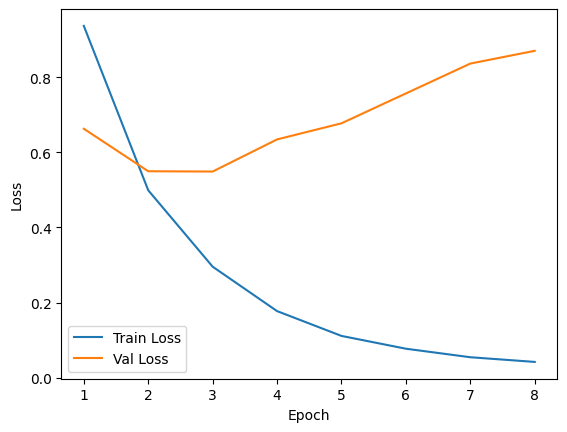

<All keys matched successfully>

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttention(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create empty lists to store loss values
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model_state = None  # Store the state dictionary of the best model
patience = 5
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_dataloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        labels = labels.float()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)  # Store train loss


    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            labels = labels.float()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)  # Store validation loss


    print("Epoch: {}/{} | Train Loss: {:.4f} | Val Loss: {:.4f}".format(epoch+1, num_epochs, epoch_loss, val_loss))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        best_model_state = model.state_dict()  # Update the best model state

    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

if len(train_losses) > 0 and len(val_losses) > 0:
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# To load the model with the best validation loss:
best_model = BiLSTMAttention(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
best_model.load_state_dict(best_model_state)


In [ ]:
import os
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=10, patience=5, device='cuda'):
    # Create a directory for storing results
    if not os.path.exists('results'):
        os.makedirs('results')
    run_id = 'run1'  # Change this to a suitable run ID
    result_dir = os.path.join('results', run_id)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    # Set up logging
    logging.basicConfig(filename=os.path.join(result_dir, 'log.txt'), level=logging.INFO)
    logger = logging.getLogger()

    # Create empty lists to store loss values
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None  # Store the state dictionary of the best model
    early_stopping_counter = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)

        for batch in progress_bar:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            labels = labels.float()
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix({'Train Loss': loss.item()})

        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)  # Store train loss

        val_loss = evaluate_model(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)  # Store validation loss

        logger.info(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            best_model_state = model.state_dict()  # Update the best model state
            save_checkpoint(model, os.path.join(result_dir, 'best_model.pt'))  # Save the best model checkpoint
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            logger.info("Early stopping triggered. Training stopped.")
            break

    if len(train_losses) > 0 and len(val_losses) > 0:
        plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
        plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(result_dir, 'loss_plot.png'))
        plt.close()

    # Load the model with the best validation loss
    best_model = model
    if best_model_state is not None:
        best_model.load_state_dict(best_model_state)

    return best_model

Test Accuracy: 0.8282
Test F1 score: 0.8272
Test Precision: 0.8281
Test Recall: 0.8277


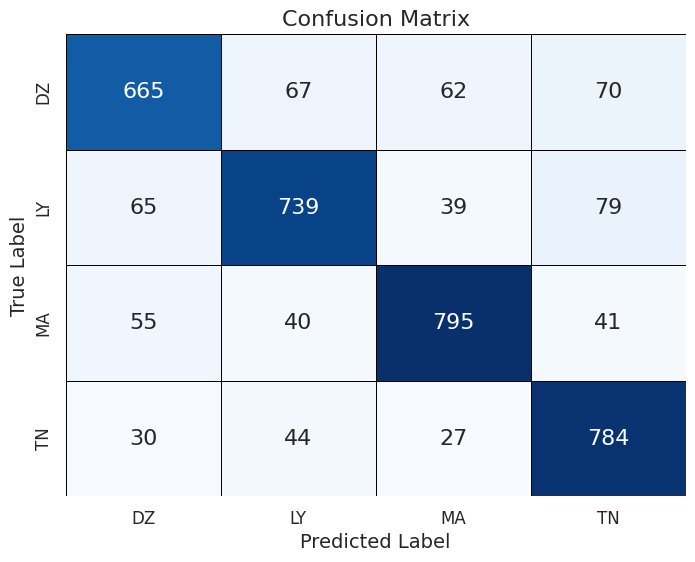

In [27]:
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
best_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch[0].to(device), batch[1].to(device)
        labels = labels.float()
        outputs, _ = best_model(inputs)
        preds = torch.softmax(outputs, dim=1)
        _, predicted_classes = torch.max(preds, dim=1)
        
        y_true.extend(labels.cpu().detach().numpy())
        y_pred.extend(predicted_classes.cpu().detach().numpy())

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# If y_true is one-hot encoded, convert it to integer labels
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)


test_acc = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='macro')
test_prec = precision_score(y_true, y_pred, average='macro')
test_recall = recall_score(y_true, y_pred, average='macro')

print('Test Accuracy: {:.4f}'.format(test_acc))
print('Test F1 score: {:.4f}'.format(test_f1))
print('Test Precision: {:.4f}'.format(test_prec))
print('Test Recall: {:.4f}'.format(test_recall))

# Calculate confusion matrix
if np.ndim(y_true) > 0 and np.ndim(y_pred) > 0:
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)

test_confusion_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, linecolor='black', ax=ax)
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)
ax.set_xticklabels(["DZ", "LY", "MA", "TN"], fontsize=12)
ax.set_yticklabels(["DZ", "LY", "MA", "TN"], fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()


In [26]:
import torch
import numpy as np


# Load the SentencePiece model
sp = spm.SentencePieceProcessor()
sp.Load("/content/maghrebi_model.model")

# Define the maximum sequence length
max_length = 128

# Define the new complaint
#new_complaint = ['واش دير للعشى']
#new_complaint  = ["شوكران علا هاد "]
#new_complaint  = ["نبي نروح للحوش"]
new_complaint  = ["فرحان و نتشرف الي انا من اقلية الشعب الي عمري ما صدقت كذبة الثورة و الديمقراطية و ما عداها عليا حتى سياسي ملي حكمو من 2011 و ما تحكموش في تفكيري باجات فيسبوك و اعلاميين مرتزقة و سبر اراء غالط"]

# Tokenize the text using SentencePiece
tokenized = sp.EncodeAsIds(new_complaint[0])

# Perform padding on the processed text
padded = pad_sequences([tokenized], maxlen=max_length, padding='post')

# Convert the padded sequence to a PyTorch tensor and move it to the device (e.g., GPU) if available
padded_tensor = torch.LongTensor(padded).to(device)

# Compute the model's prediction for the padded sequence
with torch.no_grad():
    pred = best_model(padded_tensor)

# Map the prediction to a class label using the ["DZ", "LY", "MA", "TN"]
CLASS_DICT = {0: "DZ", 1: "LY", 2: "MA", 3: "TN"}
class_label = CLASS_DICT[np.argmax(pred[0].cpu().numpy(), axis=1)[0]]

# Print the prediction and the predicted class label
print(class_label)

TN
